# Speech Commands
In this Practical work you will be given voice commands recorded by devices such as assistants. The task is to recognize the voice command from the audio signal. The dataset is stored as waveforms, each one being a 1 second file containing one voice command. The first step will be to extract speech features, either Melfilterbanks or MFCC. Then you will train different type of classifiers to recognize the spoken voice command from the speech features. These classifiers are a Logistic Regression and a Neural Network.

### Replace the path in the shell below by the one that contains the dataset

In [1]:
import numpy as np
import spectral
import librosa
import IPython
import os
import scipy.io.wavfile as wav
import sklearn
from sklearn.neural_network import MLPClassifier

# Import functions to store training results
import csv
from datetime import datetime
from log import _check_log_directory,_initialise_model_log
log_dir = '/Users/sebastienohleyer/Documents/ENS MVA/MVA_2018_SL/TD_#1/log'
log_name = (datetime.now().strftime('%d-%m-%Y_%H-%M-%S'))
log_filepath = os.path.join(log_dir,log_name,'model_results.csv')
_check_log_directory(os.path.join(log_dir,log_name))
_initialise_model_log(log_filepath)

Attempting to make log directory at /Users/sebastienohleyer/Documents/ENS MVA/MVA_2018_SL/TD_#1/log/03-02-2018_15-55-14


In [2]:
os.chdir('./speech_commands_v0.01')
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(777)

These functions are just utilities that will help facilitate features extraction. Feel free to modify them if you need to, but it is not required.

In [3]:
def txt2list(filename):
    lines_list = []
    with open(filename, 'r') as txt:
        for line in txt:
            lines_list.append(line.rstrip('\n'))
    return lines_list

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav).flatten())
    return features

def pad(features):
    max_len = 0
    padded_features =[]
    for feat_file in features:
        max_len = max(max_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = max_len - feat_file.shape[0]
        left_pad = pad_size / 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

Load the data. In this practical work, you are expected to train your models on the training set and evaluate them on the validation set. When you will get your final best model, report the results on the test set.

In [4]:
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 300
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

In [5]:
# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print "Train files: " + str(len(train_wavs))
print "Valid files: " + str(len(valid_wavs))
print "Test files: " + str(len(test_wavs))

Train files: 3000
Valid files: 1000
Test files: 1000


In [6]:
train_wavs_array = np.array(train_wavs)
valid_wavs_array = np.array(valid_wavs)
test_wavs_array = np.array(test_wavs)

In [7]:
from tqdm import tqdm

normalize = False

def normalize_speech_features(wavs):
    normalize_wavs_array = np.zeros((len(wavs), 16000))
    for idx, wav in tqdm(enumerate(wavs)):
        for i in range(len(wav)):
            normalize_wavs_array[idx,i] = wav[i]
    feat_mean = np.mean(normalize_wavs_array, axis=0, keepdims=True)
    feat_std = np.std(normalize_wavs_array, axis=0, keepdims=True)
    return normalize_wavs_array, feat_mean, feat_std

if normalize is True:
    normalize_train_wavs_array, feat_mean, feat_std = normalize_speech_features(train_wavs)
    train_wavs_array = np.divide(np.subtract(normalize_train_wavs_array, feat_mean), feat_std)
    
    normalize_valid_wavs_array,_,_ = normalize_speech_features(valid_wavs)
    valid_wavs_array = np.divide(np.subtract(normalize_valid_wavs_array, feat_mean), feat_std)

    normalize_test_wavs_array,_,_ = normalize_speech_features(test_wavs)
    test_wavs_array = np.divide(np.subtract(normalize_test_wavs_array, feat_mean), feat_std)

The following cells create feature functions that have a .transform method that takes a waveform as input. You should not change the framerate parameter (the dataset is sampled at 16kHz).
The other parameters are the following:
* nfilt = number of mel-filters to average spectrograms
* ncep = number of cepstral coefficients to use for MFCCs
* do_dct = True to compute MFCC (otherwise mel-filterbanks are the output)
* lowerf = lowest frequency spanned by the filters (and that will be taken into account by the features)
* higherf = highest frequency spanned by the filters
* alpha = parameter use for the pre-emphasis
* frate = number of frames per second (1/frate is the stride of the windows in seconds)
* wlen = length of windows in seconds
* nfft = number of frequency bins used to compute the spectrogram
* compression = the final compression performed on the mel-filterbanks (before DCT if you put do_dct=True)
* do_deltas = compute the first derivatives of MFCC
* do_deltasdeltas = compute the second derivatives of MFCC

In [8]:
framerate = 16000

# Mel-filterbanks function

In [17]:
melfbanks = spectral.Spectral(nfilt=26,
                    ncep=0,
                    do_dct=False,
                    lowerf=0,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=80,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

# MFCC function

In [18]:
mfcc = spectral.Spectral(nfilt=26,
                    ncep=13,
                    do_dct=True,
                    lowerf=0,
                    upperf=8000,
                    alpha=0.97,
                    fs=framerate,
                    frate=80,
                    wlen=0.025,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=True) 

# The following cell generates the features for train, valid and test from the waveforms

In [19]:
# Choose the feature function
feature_function = melfbanks
feature_function_name = 'melfbanks'

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()
feature_function_training_time = end-start
print "Time to output features: " + str(feature_function_training_time)

Time to output features: 37.1889119148


In [20]:
# Next cell trains a logistic regression on the speech features

In [21]:
#Logistic regression

logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-4, random_state=777, C=1.5)

start = time.time()
logreg.fit(train_feats, train_labels)
end = time.time()
log_reg_training_time = end-start
print "Training time: " + str(log_reg_training_time)

[LibLinear]Training time: 87.6565699577


# You can now evaluate it on the validation set

In [22]:
accuracy = 100*logreg.score(valid_feats, valid_labels)
print "Accuracy on valid set " + str(accuracy) + "%"

# write model results
with open(log_filepath, 'a') as fp:
    a = csv.writer(fp, delimiter=',')
    data = [[datetime.now().strftime('%d-%m-%Y_%H-%M-%S'), 'logistic_reg', accuracy,
             feature_function_name, normalize, feature_function.config, feature_function_training_time, 
             logreg.get_params(), log_reg_training_time]]
    a.writerows(data)

Accuracy on valid set 39.6%


In [23]:
neural_net = MLPClassifier(hidden_layer_sizes=(500,), validation_fraction = 0.2, early_stopping = False, activation='relu',
                                   verbose = True, random_state = 777, learning_rate='adaptive',
                                   learning_rate_init=0.001, solver='adam')

start = time.time()
neural_net.fit(train_feats, train_labels)
end = time.time()
neural_net_training_time = end-start
print "Training time: " + str(neural_net_training_time)

Iteration 1, loss = 17.48409268
Iteration 2, loss = 9.12838677
Iteration 3, loss = 3.61216696
Iteration 4, loss = 2.48684601
Iteration 5, loss = 2.09277164
Iteration 6, loss = 1.91743714
Iteration 7, loss = 1.87926972
Iteration 8, loss = 1.76878562
Iteration 9, loss = 1.71565052
Iteration 10, loss = 1.67620938
Iteration 11, loss = 1.65210060
Iteration 12, loss = 1.57915383
Iteration 13, loss = 1.51559120
Iteration 14, loss = 1.54861440
Iteration 15, loss = 1.48077430
Iteration 16, loss = 1.48063317
Iteration 17, loss = 1.44235299
Iteration 18, loss = 1.40471429
Iteration 19, loss = 1.39500636
Iteration 20, loss = 1.39049789
Iteration 21, loss = 1.35573349
Iteration 22, loss = 1.33636122
Iteration 23, loss = 1.37497930
Iteration 24, loss = 1.25850331
Iteration 25, loss = 1.26405334
Iteration 26, loss = 1.25342938
Iteration 27, loss = 1.24016281
Iteration 28, loss = 1.25346742
Iteration 29, loss = 1.37736255
Iteration 30, loss = 1.23517617
Iteration 31, loss = 1.20681094
Iteration 32, lo

# Evaluate it on the valid set

In [24]:
accuracy = 100*neural_net.score(valid_feats, valid_labels)
print "Accuracy on valid set " + str(accuracy) + "%"

# write model results
with open(log_filepath, 'a') as fp:
    a = csv.writer(fp, delimiter=',')
    data = [[datetime.now().strftime('%d-%m-%Y_%H-%M-%S'), 'neural_net', accuracy,
             feature_function_name, normalize, feature_function.config, feature_function_training_time, 
             neural_net.get_params(), neural_net_training_time]]
    a.writerows(data)

Accuracy on valid set 57.1%


# Listen to a random waveform from the training set

In [17]:
random_idx = random.randint(0, len(valid_wavs))
random_wav = valid_wavs[random_idx]
IPython.display.Audio(random_wav, rate=16000)

# Visualize mel-filterbanks and MFCC

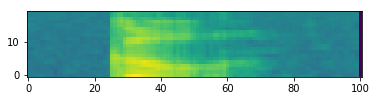

In [69]:
plt.imshow(melfbanks.transform(random_wav).transpose())
plt.gca().invert_yaxis()

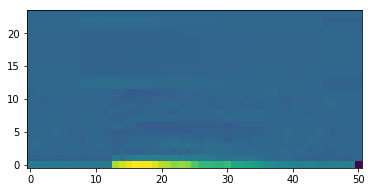

In [70]:
plt.imshow(mfcc.transform(random_wav).transpose())
plt.gca().invert_yaxis()

# See what your classifier has predicted

In [71]:
print label_set[neural_net.predict(valid_feats[random_idx][np.newaxis])[0]]

nine


# What you are expected to do in this TP
This notebook contains the different blocks that allow you to train speech commands recognizers. The results provided with the features and classifiers above are far from optimal.

You are expected to explore various ways to improve their performance. Here are the main things to try:
* The parameters of the speech features such as the min/max frequency or window size are poorly chosen, look inside the resources mentioned in the class to find the best parameters for mel-filterbanks and MFCC.
* The logistic regression can be regularized in different ways (by controlling the C parameter) and you can try to find the best one
* The neural net proposed is a shallow neural net, far from the best you can train. You should try bigger, deeper architectures, different types of regularization, activation functions, learning rate and so on
* A standard way of improving generalization is to do mean-variance normalization on your data set. This is done by computing the mean and variance of each feature dimension on the entire training set, and then use it to normalize train, valid and test set
* The dataset provides noises samples, either artificial (pink, white noise) or real (dishes, bike) in the folder _background_noise. You can try augmenting your dataset by adding noise to the waveforms before computing the features
* The model is only trained on 300 examples per class, if your hardware allows it, try training on more examples
* Feel free to also experiment with different classifiers

You should find the best model by comparing validation accuracies. After you find your best model, finally test it on the test set and print the result. Comment on the results (best model, best features, classes that are the most difficult to recognize). The grade will not depend on the performance of the final system, but on how you experimented, tried different ideas, and comment on them.

Write your comments in Markdown cells, and send the ipython notebook as your assignment. Good luck!

[Documentation for logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Documentation for neural network](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

# Results and comments

We compared the accuracy obtained with Mel-fitlerbanks and MFCC using different classifiers and we present our results for both features.

#